In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import Inception_V3_Weights
import matplotlib.pyplot as plt
import math
import scipy.linalg
from skimage.metrics import structural_similarity as ssim

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define beta schedule for diffusion
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0).to(device)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return (
        sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise
    ), noise

In [4]:
# Define diffusion parameters
T = 300
betas = linear_beta_schedule(timesteps=T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [5]:
# UNet model
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList(
            [Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)]
        )
        self.ups = nn.ModuleList(
            [Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)]
        )
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [6]:
# Dataset and utility functions
class CustomDataset(Dataset):
    def __init__(self, imgs, channel=0):
        self.imgs = imgs[:, :, :, channel]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        return self.transform(img)

def load_custom_dataset(file_path, num_samples=4096):
    with h5py.File(file_path, 'r') as file:
        imgs = np.array(file['X_jets'][:num_samples])
        print(f"Loaded {imgs.shape[0]} images with shape: {imgs[0].shape}")
    return imgs

def process_tensor_for_display(image):
    if len(image.shape) == 4:
        image = image[0]
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    if image.shape[0] == 1:
        image = image[0]
    else:
        image = image.permute(1, 2, 0)
    return image.cpu().numpy()

In [7]:
def sample(model, num_images, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn((num_images, 1, 64, 64), device=device)
        for t in range(T - 1, -1, -1):
            t_tensor = torch.full((num_images,), t, dtype=torch.long, device=device)
            predicted_noise = model(x, t_tensor)
            alpha_t = alphas[t]
            alpha_bar_t = alphas_cumprod[t]
            sigma_t = torch.sqrt(posterior_variance[t])
            if t > 0:
                z = torch.randn_like(x)
            else:
                z = torch.zeros_like(x)
            x = (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_t) + sigma_t * z
    model.train()
    return x

def predict_x0(model, x_0, t, device):
    model.eval()
    with torch.no_grad():
        x_t, _ = forward_diffusion_sample(x_0, t, device)
        predicted_noise = model(x_t, t)
        sqrt_alpha_bar_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alpha_bar_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        predicted_x_0 = (x_t - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t
    model.train()
    return predicted_x_0

In [8]:
# FID and metric computation functions
def preprocess(images):
    images = (images + 1) / 2
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images = normalize(images)
    return images

def extract_features(images, model, device, batch_size=50):
    model.eval()
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            batch = preprocess(batch)
            feat = model(batch)
            features.append(feat.cpu().numpy())
    return np.concatenate(features, axis=0)

def compute_statistics(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def fid_from_stats(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = scipy.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def compute_fid(real_images, generated_images, device):
    if real_images.shape[1] == 1:
        real_images = real_images.repeat(1, 3, 1, 1)
    if generated_images.shape[1] == 1:
        generated_images = generated_images.repeat(1, 3, 1, 1)
    inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False).to(device)
    inception.eval()
    inception.fc = nn.Identity()
    real_features = extract_features(real_images, inception, device)
    gen_features = extract_features(generated_images, inception, device)
    mu_r, sigma_r = compute_statistics(real_features)
    mu_g, sigma_g = compute_statistics(gen_features)
    fid = fid_from_stats(mu_r, sigma_r, mu_g, sigma_g)
    return fid

def compute_ssim(original, reconstructed):
    original_np = process_tensor_for_display(original)
    reconstructed_np = process_tensor_for_display(reconstructed)
    return ssim(original_np, reconstructed_np, data_range=original_np.max() - original_np.min())

def compute_psnr(original, reconstructed):
    mse = F.mse_loss(original, reconstructed).item()
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

In [9]:
def visualize_forward_diffusion(image, T, device, num_images=10):
    stepsize = int(T / num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        idx = i * stepsize
        t = torch.tensor([idx], dtype=torch.int64, device=device)
        img, _ = forward_diffusion_sample(image, t, device)
        img_np = process_tensor_for_display(img)
        ax.imshow(img_np, cmap='viridis')
        ax.set_title(f"t={idx}")
        ax.axis('off')
    plt.suptitle("Forward Diffusion Process", fontsize=16)
    plt.tight_layout()
    plt.show()

Loaded 4096 images with shape: (125, 125, 3)


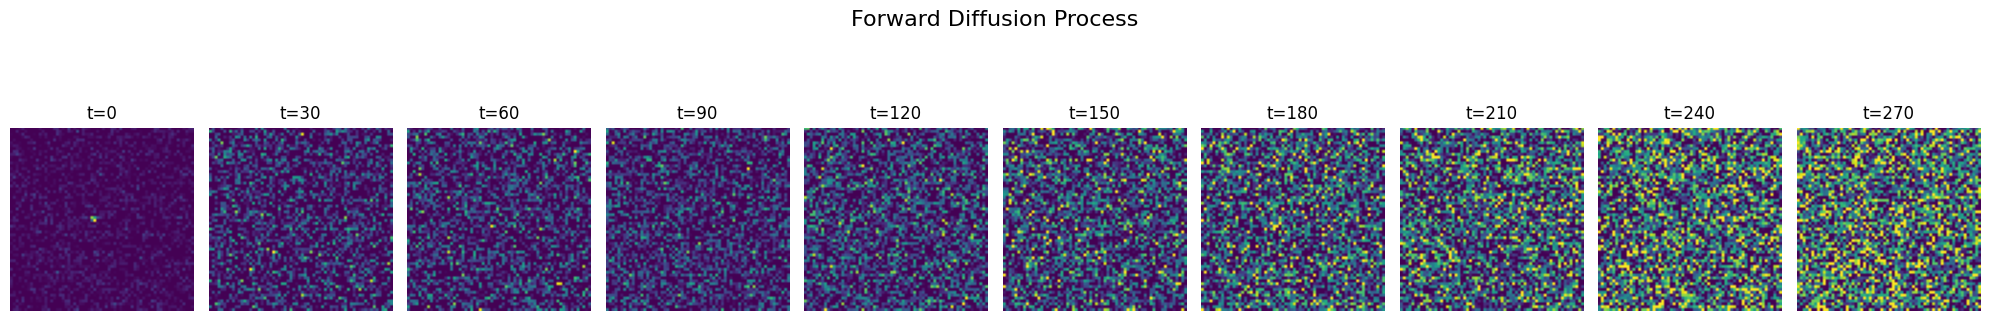

Num params:  62437601
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 141MB/s]  


Epoch 1/10 - Loss: 0.5196, FID: 247.0825, Recon MSE: 0.4905, SSIM: 0.0000, PSNR: 3.10
Epoch 2/10 - Loss: 0.1427, FID: 233.5903, Recon MSE: 0.1161, SSIM: -0.0000, PSNR: 9.36
Epoch 3/10 - Loss: 0.0995, FID: 248.7196, Recon MSE: 0.0887, SSIM: 0.0000, PSNR: 10.53
Epoch 4/10 - Loss: 0.0815, FID: 285.0443, Recon MSE: 0.0730, SSIM: 0.0000, PSNR: 11.37
Epoch 5/10 - Loss: 0.0666, FID: 329.1293, Recon MSE: 0.0603, SSIM: 0.0000, PSNR: 12.20
Epoch 6/10 - Loss: 0.0556, FID: 321.3131, Recon MSE: 0.0471, SSIM: -0.0000, PSNR: 13.27
Epoch 7/10 - Loss: 0.0475, FID: 385.9300, Recon MSE: 0.0389, SSIM: 0.0000, PSNR: 14.10
Epoch 8/10 - Loss: 0.0394, FID: 331.8412, Recon MSE: 0.0331, SSIM: -0.0000, PSNR: 14.81
Epoch 9/10 - Loss: 0.0354, FID: 275.1120, Recon MSE: 0.0298, SSIM: 0.0001, PSNR: 15.26
Epoch 10/10 - Loss: 0.0310, FID: 322.3817, Recon MSE: 0.0276, SSIM: 0.0000, PSNR: 15.60


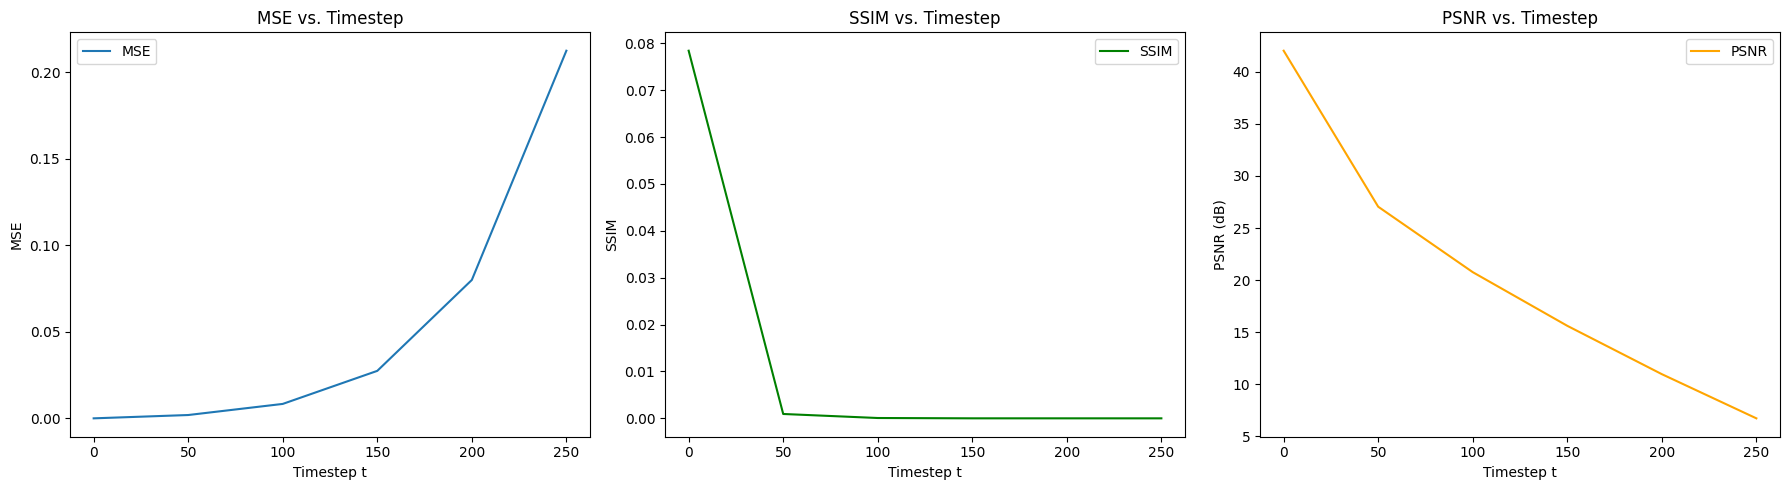

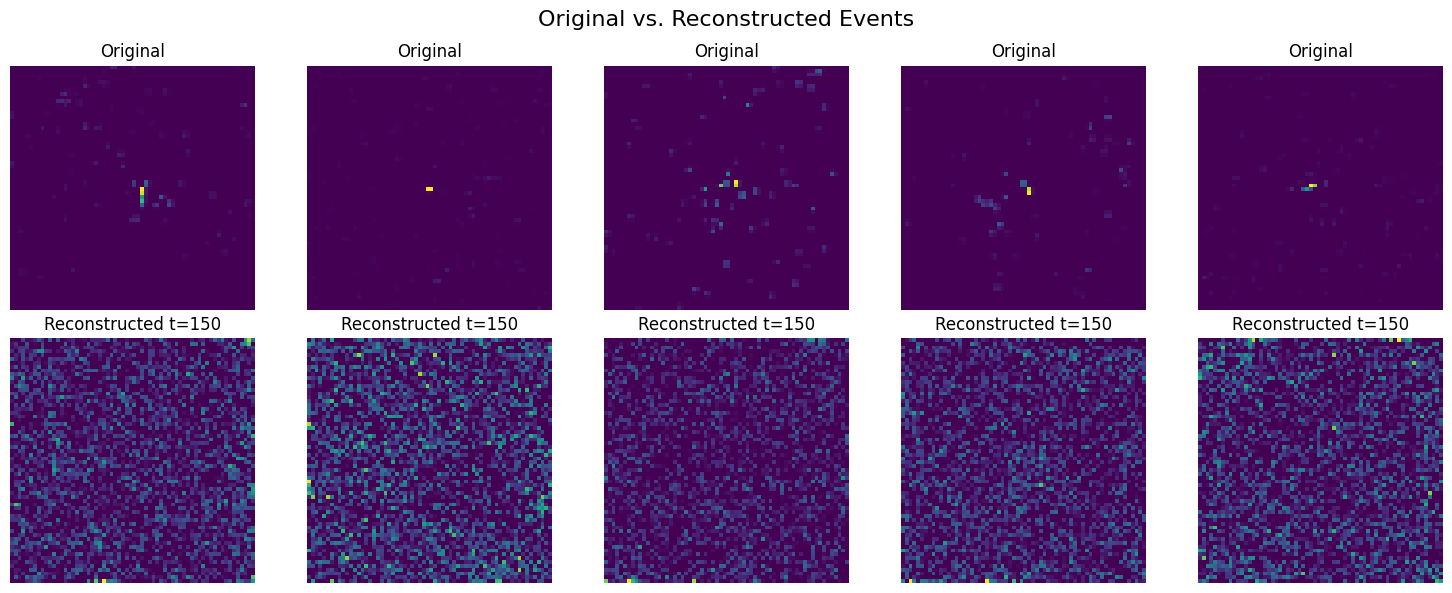

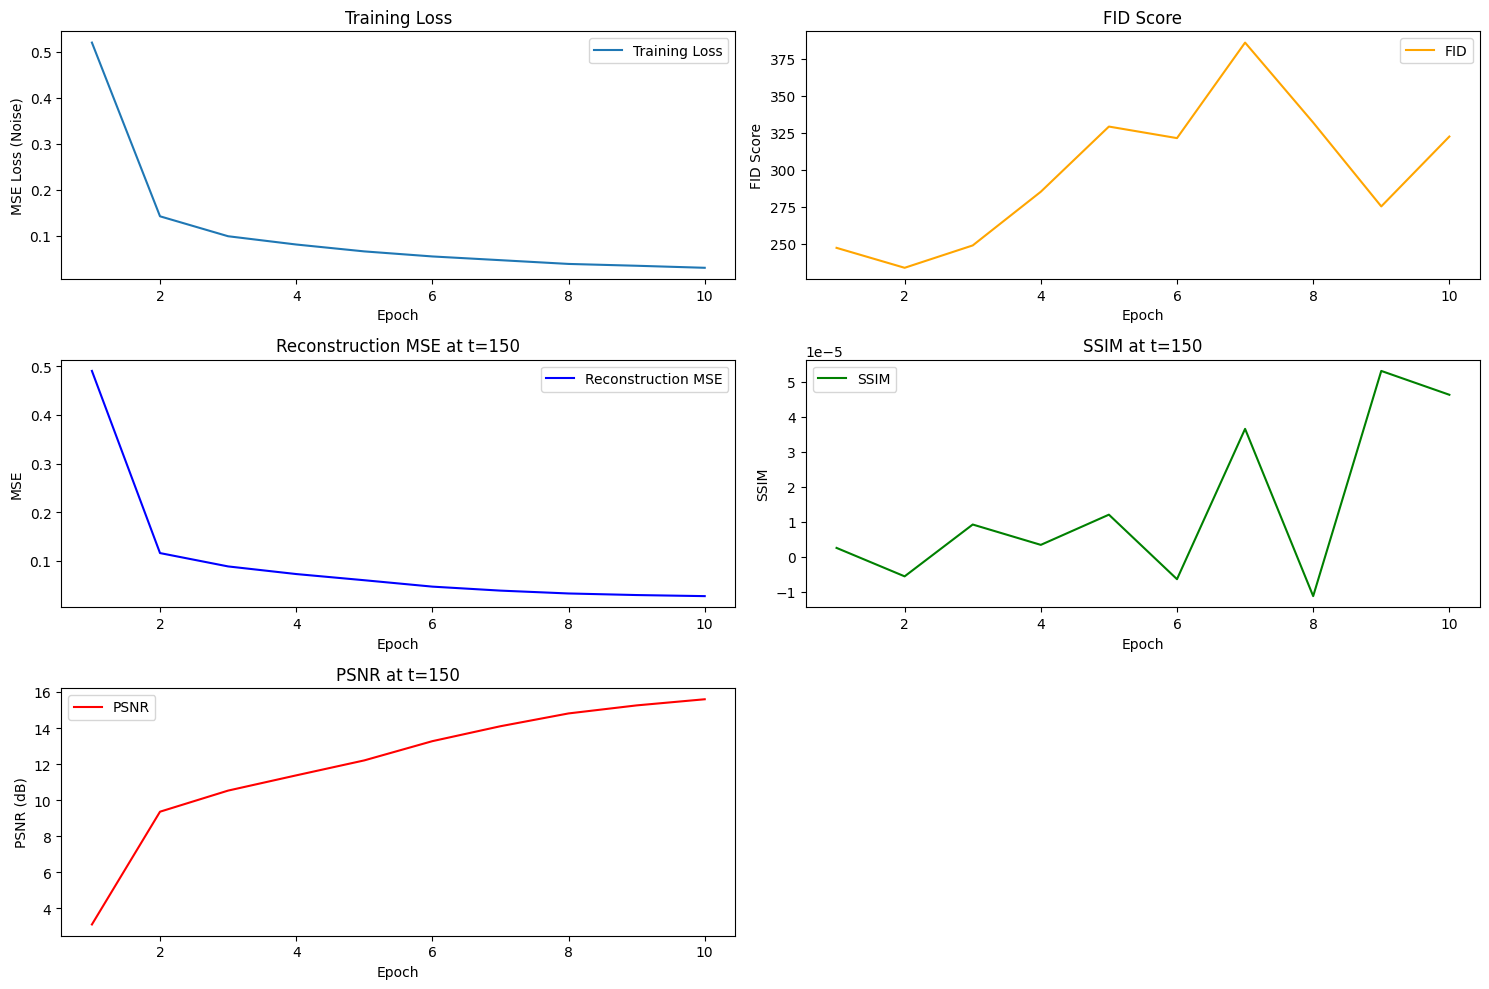

In [10]:
# Main execution
if __name__ == "__main__":
    # Parameters
    IMG_SIZE = 32
    BATCH_SIZE = 128
    FILE_PATH = 'large_file.hdf5'
    NUM_SAMPLES = 4096
    CHANNEL = 0
    EPOCHS = 10
    LEARNING_RATE = 1e-4

    # Load dataset
    train_imgs = load_custom_dataset(FILE_PATH, num_samples=NUM_SAMPLES)
    dataset = CustomDataset(train_imgs, channel=CHANNEL)

    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Visualize forward diffusion
    sample_image = next(iter(train_loader))[0].to(device)
    visualize_forward_diffusion(sample_image, T, device)

    # Model and training
    model = SimpleUnet().to(device)
    print("Num params: ", sum(p.numel() for p in model.parameters()))
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Add lists for all metrics**
    losses = []
    fid_scores = []
    mse_scores = []
    ssim_scores = []
    psnr_scores = []

    # Training loop with reconstruction metrics**
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            t = torch.randint(0, T, (batch_size,), device=device).long()
            x_t, noise = forward_diffusion_sample(x_0, t, device)
            predicted_noise = model(x_t, t)
            loss = F.mse_loss(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            num_fid_samples = min(1000, len(val_dataset))
            generated_images = sample(model, num_fid_samples, device)
            real_images = next(iter(val_loader)).to(device)[:num_fid_samples]
            fid_score = compute_fid(real_images, generated_images, device)
            fid_scores.append(fid_score)

            # Compute reconstruction metrics at t=150
            t_recon = 150
            t = torch.full((real_images.size(0),), t_recon, device=device).long()
            predicted_x_0 = predict_x0(model, real_images, t, device)
            mse = F.mse_loss(predicted_x_0, real_images).item()
            ssim_values = [compute_ssim(real_images[i], predicted_x_0[i]) for i in range(real_images.size(0))]
            psnr_values = [compute_psnr(real_images[i], predicted_x_0[i]) for i in range(real_images.size(0))]
            avg_ssim = np.mean(ssim_values)
            avg_psnr = np.mean(psnr_values)
            mse_scores.append(mse)
            ssim_scores.append(avg_ssim)
            psnr_scores.append(avg_psnr)

            print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {avg_loss:.4f}, FID: {fid_score:.4f}, Recon MSE: {mse:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}")

    # After training, evaluate reconstruction with MSE, SSIM, PSNR
    model.eval()
    with torch.no_grad():
        subset_size = 100
        val_subset = torch.utils.data.Subset(val_dataset, range(subset_size))
        val_loader_subset = DataLoader(val_subset, batch_size=subset_size, shuffle=False)
        x_0_batch = next(iter(val_loader_subset)).to(device)

        t_values = range(0, T, 50)
        mse_list, ssim_list, psnr_list = [], [], []
        for t_val in t_values:
            t = torch.full((subset_size,), t_val, device=device).long()
            predicted_x_0 = predict_x0(model, x_0_batch, t, device)
            mse = F.mse_loss(predicted_x_0, x_0_batch).item()
            ssim_val = np.mean([compute_ssim(x_0_batch[i], predicted_x_0[i]) for i in range(subset_size)])
            psnr_val = np.mean([compute_psnr(x_0_batch[i], predicted_x_0[i]) for i in range(subset_size)])
            mse_list.append(mse)
            ssim_list.append(ssim_val)
            psnr_list.append(psnr_val)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes[0].plot(t_values, mse_list, label='MSE')
        axes[0].set_xlabel('Timestep t')
        axes[0].set_ylabel('MSE')
        axes[0].set_title('MSE vs. Timestep')
        axes[0].legend()

        axes[1].plot(t_values, ssim_list, label='SSIM', color='green')
        axes[1].set_xlabel('Timestep t')
        axes[1].set_ylabel('SSIM')
        axes[1].set_title('SSIM vs. Timestep')
        axes[1].legend()

        axes[2].plot(t_values, psnr_list, label='PSNR', color='orange')
        axes[2].set_xlabel('Timestep t')
        axes[2].set_ylabel('PSNR (dB)')
        axes[2].set_title('PSNR vs. Timestep')
        axes[2].legend()
        plt.tight_layout()
        plt.show()

        num_vis = 5
        t_vis = 150
        t = torch.full((num_vis,), t_vis, device=device).long()
        x_0_vis = x_0_batch[:num_vis]
        predicted_x_0_vis = predict_x0(model, x_0_vis, t, device)

        fig, axes = plt.subplots(2, num_vis, figsize=(15, 6))
        for i in range(num_vis):
            axes[0, i].imshow(process_tensor_for_display(x_0_vis[i]), cmap='viridis')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            axes[1, i].imshow(process_tensor_for_display(predicted_x_0_vis[i]), cmap='viridis')
            axes[1, i].set_title(f'Reconstructed t={t_vis}')
            axes[1, i].axis('off')
        plt.suptitle('Original vs. Reconstructed Events', fontsize=16)
        plt.tight_layout()
        plt.show()

    # **Modified: Plot all training metrics**
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 2, 1)
    plt.plot(range(1, EPOCHS + 1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (Noise)')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(range(1, EPOCHS + 1), fid_scores, label='FID', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.title('FID Score')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(range(1, EPOCHS + 1), mse_scores, label='Reconstruction MSE', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Reconstruction MSE at t=150')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(range(1, EPOCHS + 1), ssim_scores, label='SSIM', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('SSIM at t=150')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(range(1, EPOCHS + 1), psnr_scores, label='PSNR', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR at t=150')
    plt.legend()

    plt.tight_layout()
    plt.show()